# <font color=darkcyan> Variational inference </font>
#### <font color=darkorange>Basics: Evidence Lower Bound (ELBO) & Coordinate Ascent Variational Inference (CAVI) </font>


[formula 1](#cell1)


In [ ]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import multivariate_normal
from IPython.display import HTML
from matplotlib import animation, rc
import warnings
from sklearn.metrics.cluster import adjusted_rand_score

<font color=darkred>Mixture of Gaussian distributions.</font>

Following the example in the article``Variational Inference: A Review for Statisticians, Blei et al; (2017)``, we consider a Bayesian mixture of unit-variance univariate Gaussians. 

1. There are $K$ mixture components with means $\mu = \{\mu_1, \cdots, \mu_K \}$, each component $k$ of the mixture is a Gaussian distribution with mean $\mu_k$ and covariance matrix $I_d$. 

$$x|\mu_k \sim p(x|\mu_k) = \mathcal{N}(\mu_k, I_d)$$

2. The clusters' mean are random variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ assumed to be independent and identically distributed (i.i.d.) with Gaussian distribution with mean 0 and variance $\Sigma$.

$$\mu_k \sim \mathcal{N}(0, \Sigma)\$$

3. The generate a data point $x$, we first have to identify its clusters. For that we use an assignment variable $c$ that indicates which latent cluster $k$ to draw from. In this model all clusters have the same chance ($1/K$) to be chosen for drawing a data point so $c$ is the following categorical variable.

$$c \sim categorical (1/K, \cdots, 1/K)$$


From that, data points $(x_i)_{1 \leq i \leq n}$ are supposed to be generated following the generative history:

\begin{align*}
\mu_k &\sim \mathcal{N}(0, \Sigma) && \text{$k = 1 \cdots K$}\\
c_i &\sim categorical (1/K, \cdots, 1/K) && \text{$i = 1 \cdots n$}\\
x_i|c_i, \mu &\sim p(x|\mu_{c_i}) = \mathcal{N}(\mu_{c_i}, I_d)  && \text{$i = 1 \cdots n$}\\
\end{align*}



For a sample of size $n$, the joint density of latent and observed variables is: 

$$p(\mu, c, x) = p(\mu) \prod_{i=1}^{n} p(c_i)p(x_i|c_i, \mu)$$

The evidence is then
$$
p(x) = p(x_1,\cdots,x_n) = \int p(\mu) \prod_{i=1}^{n} \sum_{c_i} p(c_i) P(x_i|c_i, \mu) d\mu
$$

**Application** with $K= 5$, $\Sigma = \begin{bmatrix}
10 & 8\\
8 & 10
\end{bmatrix}$, $p(c_i = k) = 1/K$ for all $1\leqslant k \leqslant K$.

We generate $n=2000$ samples for the experiment. Also data points are in dimension $dim = 2$. 

In [ ]:
# Sample data
np.random.seed(2) # Seed to ensure reproducibility
dim = 2
K  = 5 # Number of mixture components
sigma2 = np.array([[10,8], # Covariance matrix for the means of the clusters (each mean has the same covariance matrix)
                   [8,10]])

In [ ]:
mu = np.random.multivariate_normal([0,0], sigma2, K) # Means of the distribution in each cluster
n_samples = 2000 # Number of samples

In [ ]:
mu

array([[ 1.30654037,  1.19400671],
       [ 4.76831748,  8.0488591 ],
       [ 6.22205412,  4.53855939],
       [-0.26335616, -2.75393234],
       [ 4.08286427,  2.26484904]])

In [ ]:
idx = np.random.randint(0, K, n_samples) # The equivalent of c_i in the paper. It's the index of x_i's cluster. Array of size n_samples
# mu[idx] is the mean of the cluster in which each x_i is (it is an array)
X = np.random.normal(0, 1, size=(n_samples, dim)) + mu[idx] # We draw each x_i according to a Gaussian law with mean mu[idx][i] and variance 1. Array of size n_samples * dim

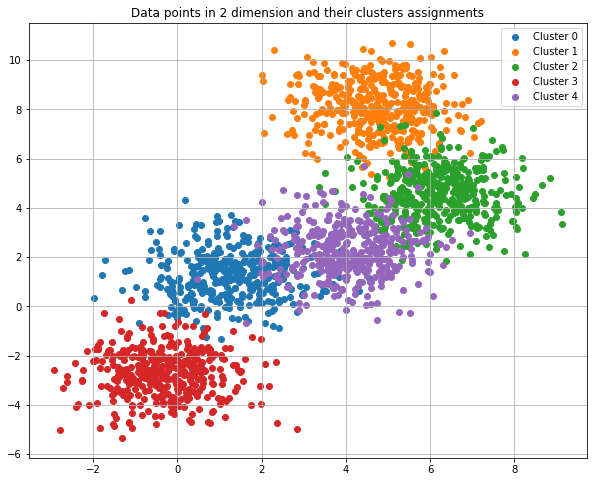

In [ ]:
plt.figure(figsize=(10,8))
plt.grid(True)
for i in range(K):
    plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"Cluster {i}")
    
plt.title("Data points in 2 dimension and their clusters assignments")
plt.legend()


Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations. 
In a generic form, we what to compute the posterior $p(z|x) = \frac{p(x, z)}{p(x)}$. In general, we can't compute the evidence $p(x) = \int p(x,z) dz$ in a reasonnable time. For example in the case of bayesian mixture model $p(x)$ has the following complicated with a complexity exponential in $K$. 
$$
p(x) = \int p(\mu) \prod_{i=1}^{n} \sum_{c_i} p(c_i) P(x_i|c_i, \mu) d\mu
$$

# <font color=darkcyan> The idea behind Variational inference </font>

Because the intractable evidence, we use variational methods to approch the posterior.

In variational inference, 
the idea is to pick a family of possible candidates distributions over the latent variable $Q$. Each element $q(z)$ in that family is a candidate that approximates the posterior and our goal is to find the best one $q^*$ in that family which is the one that minimizes the $KL$ divergence to the exact posterior. 

$$
q^* =  \arg \min_{q \in \mathcal{Q}} \mathrm{KL}\left(q(z)\|p(z|x)\right)\,.
$$

Note that
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

where the ``Evidence Lower Bound`` (ELBO) is

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

* Therefore, ``minimizing the KL divergence`` pares down to maximizing the ELBO, where $\log p(x)\geqslant \mathrm{ELBO}(q)$.

* The complexity of the family $\mathcal{Q}$ determines the complexity of the optimization.


## <font color=darkred> Proof of the update equation of the variational distribution with CAVI for the Mean-field family</font>

### <font color=darkred>**Mean field family**</font>

In this section, we focus on the mean-field variational family, where the latent variables are mutually independent and each governed by a distinct factor in the variational density. 
A member of this family is like the following

\begin{align*}
\mathrm{q}(z)&= \prod_{j=1}^{m} q_j(z_j) && \text{where m is the dimension of the hidden variable $z$ and $z_j \sim q_j(z_j)$.}
\end{align*}

### <font color=darkred>Generic CAVI algorithm.</font>


One of the most commonly used algorithms for solving this optimization problem is **CAVI**(coordinate ascent variational inference (CAVI) (Bishop 2006). CAVI iteratively optimizes each factor of the mean-field variational density, while
holding the others fixed.
    
- Fixing all $(q_m)_{m \neq j} $ expect $q_j$, we optimize the ``ELBO`` over $q_j$. Then the $\mathrm{ELBO}$ is as the following:


\begin{align*}
\mathrm{ELBO}(q) &= \mathrm{ELBO}(q_j)\\ 
&=  \mathbb{E}_q \left[ \log p(z_j| x, z_{-j}) + \log p( x, z_{-j}) - \sum_{k=1}^{m} \log q_j(z_j) \right]\\ 
&= \mathbb{E}_{q_j} \left[ 
  \mathbb{E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j}) + \log p( x, z_{-j}) - \sum_{k=1}^{m} \log q_j(z_j) | z_j \right] \right]\\
&= \mathbb{E}_{q_j} \left[ 
  \mathbb{E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j}) - \log q_j(z_j) | z_j \right] \right] + cst\\
&= \mathbb{E}_{q_j} \left[  \mathbb{E}_{X, Z_{-j}} \left[ F \left(q_j(z_j) , \log p(z_j| x, z_{-j}) \right) | z_j \right] \right] + cst
\end{align*}


or $\arg \max_{q_j} \mathbb{E}_{q}[ \cdots ] \Leftrightarrow \arg \max_{q_j} \mathbb{E}_{X, Z_{-j}} \left[ F \left(q_j(z_j) , \log p(z_j| x, z_{-j}) \right) | z_j \right]  \text{for each $z_j$}$ 


So the maximizer $q^*_{j}$ verify 
\begin{align*}
q^*_{j}(z_j) &= \arg \max {E}_{X, Z_{-j}} \left[ f(q_j(z_j) , \log p(z_j| x, z_{-j})) | z_j \right])\,\\ 
&= \arg \max {E}_{X, Z_{-j}} \left[ -  \log q_j(z_j) +  \log p(z_j| x, z_{-j}) \right]\,\\ 
&= -  \log q_j(z_j) + {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] + \mathbb{cst} 
\end{align*}

So we have $q^*_{j}(z_j)$ verifies the following equations:

$$\frac{-\partial \log q^*_j(z_j)}{\partial q_j(z_j)} + \frac{\partial {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] }{\partial q_j(z_j)} = 0$$ 

$$\frac{\partial \log q^*_j(z_j)}{\partial z_j} = \frac{\partial {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] }{\partial z_j}$$ 


<a id='cell1'></a>
So finally 

$$ \boxed{q^*_j(z_j) \propto \exp ({E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right])} (1)$$ 

# <font color=darkcyan> Application to the mixture of Gaussian distributions.</font>

Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations.  The mean-field variational family is described as follows:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i)\,, 
$$

which means that:

- $\mu$ and $c$ are independent.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ are independent with Gaussian distribution with means $(m_{k})_{1\leqslant k \leqslant K}$ and covariances $(\Sigma _{k})_{1\leqslant k \leqslant K}$.



- $(c_{i})_{1\leqslant i \leqslant n}$ are independent with multinomial distribution with parameters $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ for $1\leqslant k \leqslant K$. 

The family of such distributions is parameterized by $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^{d \times K}$, the covariance matrices $(\Sigma_{k})_{1\leqslant k \leqslant K}\in (\mathbb{S_d(R)}_+)^K$ and $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ where $\mathcal{S}_K$ is the $K$-dimensional probability simplex. 

### <font color=darkred> Update of $(\phi_i)_{1\leqslant i \leqslant n}$ using CAVI.</font>

We apply the update [formula](#cell1) of the variational distribution to our mixture of gaussian distributions model.

And so we have:
\begin{align*}
q^*_i(c_i) &\propto \exp ({E}_{-c_j} \left[ \log p(c_j| x,\mu, c_{-j})\right]) \\
&\propto \exp ({E}_{-c_j} \left[ \log p(c_j, x,\mu, c_{-j})\right])
\end{align*}

* Under $-c_i$ (all variables except $c_j$, we can reduce the factor $p(c_j, x, \mu, c_{-j})$ and keep only factor dependent on $c_i$:

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu) p(c_i) 
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n  p(c_i) \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}
  \\
  &\propto p(c_i) \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}} && \text{Other terms don't depend on ci so we can get rid of them.} 
\end{align*}

then 
\begin{align*}
q^*_i(c_i = k) & \propto p(c_i = k) \exp (p(c_i = k) \exp ({E}_{\mu_k \sim \mathcal{N}(m_k,\Sigma_k)} \left[ \log p(x_i | \mu_k) \right]) && \text{with $x_i | \mu_k \sim \mathcal{N}(\mu_k, {I}_d)$}\\
&\propto p(c_i = k) \exp ( {E}_{\mu_k \sim \mathcal{N}(m_k,\Sigma_k)} \left[x_i^T.\mu_k - \frac{||\mu_k||_2^2}{2} \right]) \\
q^*_i(c_i = k) &\propto p(c_i = k) \exp (x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_{k}) }{2})
\end{align*}

So finally 

$$\boxed{phi_i(k) \propto p(c_i = k) \exp (x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_{k}) }{2}) }$$

In [ ]:
# Function to update phi in CAVI algorithm
def CAVI_update_phi(X, m, s2):
    """
    :param X: our data points
    :param m: estimated mean in the law q
    :param s2: estimated variance in the law q
    :return: the updated phi
    """
    
    first_term = X @ mu.T

    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    x = first_term + second_term
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

### <font color=darkred>Computation of the $\mathrm{ELBO}$.</font>

We have 
$
\mathrm{ELBO}(q) = \mathrm{ELBO}((m_k)_k, (\Sigma_k)_{k}, (\phi_i)_i)  = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$

Avec 
$\mu_k \sim \mathcal{N}(m_k,\Sigma_k)\$ and 

$
\varphi_{m_k,\Sigma_k}(\mu_k) = (2\pi)^{-d}  (\det(\Sigma_k)^{\frac{-1}{2}} \exp(-\frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2})
$


$d$ being the feature dimension of our data.


1.  First of all we have:
\begin{align*}
q(\mu,c) &= \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i) 
  = \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k) \prod_{i=k}^n  \prod_{i=1}^K{\phi_i}(c_i = k)^{\mathbb{1}_{c_i = k}}\,,\\
\end{align*}

Same for $p(\mu,c,x)$, we have:

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu)
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}
  \\
\end{align*}


And so we have: 
\begin{align*}
\log q(\mu,c) &= \sum_{i=1}^n \sum_{k=1}^K \mathbb{1}_{c_i = k} \log({\phi_i}(k)) + \sum_{k=1}^K - \frac{\log(\det(\Sigma_k)}{2} - \frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2} + \mathrm{cst}\,,\\ 
\end{align*}
and
\begin{align*}
\log p(x, \mu,c) &= \sum_{i=1}^n \sum_{k=1}^K  \mathbb{1}_{c_i = k} \left[- \frac{\log(\det(I))}{2} - \frac{(x_i - \mu_k)^{T} (x_i - \mu_k)}{2} \right] 
+ \sum_{k=1}^{K} -\frac{\log(\det (\Sigma))}{2} - \frac{\mu_k^{T}\Sigma^{-1}\mu_k}{2} + \mathrm{cst} \\ 
\end{align*}

2. Knowing that 
\begin{align*}
\mathbb{E}_{\mathcal{N}(m_k,\Sigma_k)} ((\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)
&= \mathbb{E}(\mathrm{Tr}(Σ_k^{-1} (\mu_k - m_k)(\mu_k - m_k)^{T})) \\ 
&= \mathrm{Tr}(Σ_k^{-1} \mathbb{E} ((\mu_k - m_k)(\mu_k - m_k)^{T} ))\\
&= \mathrm{Tr}(Σ_k^{-1} Σ_k) = d
\end{align*}
,
\begin{align*}
\mathbb{E} \left[ (x_i - \mu_k)^{T} (x_i - \mu_k) \right] &=  \mathbb{E} \left[ \mu_k^{T}\mu_k -2\mu_k^{T}x_i + x_i^{T}x_i \right]\,\\
&= \mathbb{E} \left[ \mu_k^{T}\mu_k \right] -2m_k^{T}x_i +\mathbb{cst}\,\\ 
&= m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i + \mathbb{cst}
\end{align*}

and finally 
\begin{align*}
\mathbb{E} \left[ \mu_k^{T}\Sigma^{-1}\mu_k \right] &= \mathbb{E} \left[ \mathrm{Tr} (\mu_k^{T}\Sigma^{-1}\mu_k) \right] \,\\ 
&= \mathbb{E} \left[ \mathrm{Tr} (\Sigma^{-1}\mu_k \mu_k^{T}) \right] \,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} \mathbb{E} (\mu_k \mu_k^{T}) \left[  \right])\,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} (m_k m_k^{T} + \Sigma_{k}))\,\\
&=  m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})
\end{align*}

We have 
\begin{align*}
\mathrm{ELBO}(q) &= \mathrm{ELBO}(m, s^{2}, \phi)\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2} \,\\
&+ \sum_{i=1}^n \sum_{k=1}^K - \phi_i(k) \log(\phi_i(k)) - \phi_i(k) (\frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i}{2})\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2}
+ \sum_{i=1}^n \sum_{k=1}^K \phi_i(k) \left[ m_k^{T}x_i - \log(\phi_i(k)) - \frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k)}{2}\right]
\end{align*}

In [ ]:
## Function to update sigma_k and m_k
def CAVI_update_mu_s2(X, phi, sigma2, K, dim):
    """
    :param X: our data points
    :param phi: estimated phi in the law q
    :param sigma2: covariance matrix of the means of the clusters
    :param K: number of clusters
    :param dim: number of dimensions of the problem
    :return: the updated m and s2
    """

    p = phi.T.sum(axis=1, keepdims=True)
    s2_inv = np.linalg.inv(sigma2) + p.reshape(-1,1)[:,:,None]*np.identity(dim)
    s2 = np.linalg.inv(s2_inv)

    a = (phi.T @ X)
    m  = (s2 @ a[:,:,None])[:,:,0]
    return m, s2

<font color=darkred>Computation of the $\mathrm{ELBO}$.</font>

We have 
$
\mathrm{ELBO}(q) = \mathrm{ELBO}((m_k)_k, (\Sigma_k)_{k}, (\phi_i)_i)  = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$

Avec 
$\mu_k \sim \mathcal{N}(m_k,\Sigma_k)\$ and 

$
\varphi_{m_k,\Sigma_k}(\mu_k) = (2\pi)^{-d}  (\det(\Sigma_k)^{\frac{-1}{2}} \exp(-\frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2})
$


$d$ being the feature dimension of our data.


1.  First of all we have:
\begin{align*}
q(\mu,c) &= \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i) 
  = \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k) \prod_{i=k}^n  \prod_{i=1}^K{\phi_i}(c_i = k)^{\mathbb{1}_{c_i = k}}\,,\\
\end{align*}

Same for $p(\mu,c,x)$, we have:

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu)
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}
  \\
\end{align*}


And so we have: 
\begin{align*}
\log q(\mu,c) &= \sum_{i=1}^n \sum_{k=1}^K \mathbb{1}_{c_i = k} \log({\phi_i}(k)) + \sum_{k=1}^K - \frac{\log(\det(\Sigma_k)}{2} - \frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2} + \mathrm{cst}\,,\\ 
\end{align*}
and
\begin{align*}
\log p(x, \mu,c) &= \sum_{i=1}^n \sum_{k=1}^K  \mathbb{1}_{c_i = k} \left[- \frac{\log(\det(I))}{2} - \frac{(x_i - \mu_k)^{T} (x_i - \mu_k)}{2} \right] 
+ \sum_{k=1}^{K} -\frac{\log(\det (\Sigma))}{2} - \frac{\mu_k^{T}\Sigma^{-1}\mu_k}{2} + \mathrm{cst} \\ 
\end{align*}

2. Knowing that 
\begin{align*}
\mathbb{E}_{\mathcal{N}(m_k,\Sigma_k)} ((\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)
&= \mathbb{E}(\mathrm{Tr}(Σ_k^{-1} (\mu_k - m_k)(\mu_k - m_k)^{T})) \\ 
&= \mathrm{Tr}(Σ_k^{-1} \mathbb{E} ((\mu_k - m_k)(\mu_k - m_k)^{T} ))\\
&= \mathrm{Tr}(Σ_k^{-1} Σ_k) = d
\end{align*}
,
\begin{align*}
\mathbb{E} \left[ (x_i - \mu_k)^{T} (x_i - \mu_k) \right] &=  \mathbb{E} \left[ \mu_k^{T}\mu_k -2\mu_k^{T}x_i + x_i^{T}x_i \right]\,\\
&= \mathbb{E} \left[ \mu_k^{T}\mu_k \right] -2m_k^{T}x_i +\mathbb{cst}\,\\ 
&= m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i + \mathbb{cst}
\end{align*}

and finally 
\begin{align*}
\mathbb{E} \left[ \mu_k^{T}\Sigma^{-1}\mu_k \right] &= \mathbb{E} \left[ \mathrm{Tr} (\mu_k^{T}\Sigma^{-1}\mu_k) \right] \,\\ 
&= \mathbb{E} \left[ \mathrm{Tr} (\Sigma^{-1}\mu_k \mu_k^{T}) \right] \,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} \mathbb{E} (\mu_k \mu_k^{T}) \left[  \right])\,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} (m_k m_k^{T} + \Sigma_{k}))\,\\
&=  m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})
\end{align*}

We have 
\begin{align*}
\mathrm{ELBO}(q) &= \mathrm{ELBO}((m_k)_k, (\Sigma_k)_{k}, (\phi_i)_i)\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2} \,\\
&+ \sum_{i=1}^n \sum_{k=1}^K - \phi_i(k) \log(\phi_i(k)) - \phi_i(k) (\frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i}{2})\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2}
+ \sum_{i=1}^n \sum_{k=1}^K \phi_i(k) \left[ m_k^{T}x_i - \log(\phi_i(k)) - \frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k)}{2}\right]
\end{align*}

In [ ]:
def elbo(X,phi,m,s2,sigma2):
    eps = 1e-8
    phi = phi + eps
    t1 = np.linalg.det(s2)
    t1 = t1 - (m[:,None,:] @ np.linalg.inv(sigma2)@m[:,:,None]).flatten()  - (np.linalg.inv(sigma2) @ s2).trace(axis1=-2, axis2=-1)
    #print(t1.shape)
    t1 = t1.sum()/2

    second_term = -(np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1))/2
    second_term = second_term.reshape(1,-1)
    #print(second_term.shape)
    second_term = (X @ m.T - np.log(phi)) + second_term
    second_term = second_term*phi
    t2 = second_term.sum()
    return t1 + t2

In the next cell we have the code of the CAVI algorithm for the gaussian mixture model. We have chosen to stop the algorithm when the $ELBO$ doesn't move anymore meaning that:
$$|ELBO_{t+1} - ELBO_{t}| \leq \epsilon$$  with $\epsilon = 10^{-2}$

In [ ]:
def CAVI_mixture_Gaussian(X, m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-2):
    elbos  = [elbo(X, phi, m, s2, sigma2)]
    m_est  = [m]
    s2_est = [s2]
    phi_est = [phi]

    k, dim = phi.shape[1] , m.shape[1] 
    for it in range(1, max_iter + 1):
        phi = CAVI_update_phi(X, m, s2)
        m, s2 = CAVI_update_mu_s2(X, phi, sigma2, K, dim)
    
        m_est.append(m)
        s2_est.append(s2)
        phi_est.append(phi)

        elbos.append(elbo(X, phi, m, s2, sigma2))

        if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
            break

    return elbos, m_est, s2_est, phi_est

<font color=darkred> Run the algorithm.</font>

In [ ]:
# Initialization
phi_init = np.random.dirichlet([np.random.random() * np.random.randint(1, 10)] * K, n_samples)
m_init = np.random.normal(0, 10, (K, dim))
s2_init = np.random.normal(0, 10, (K, dim, dim))
sigma2_init = np.array([[1, 0],
                        [0, 1]])
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)

(2000, 5)
(5, 2, 2)
(5, 2)


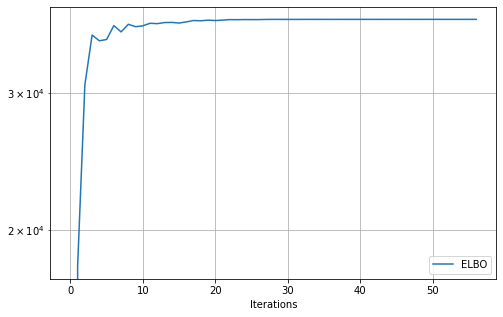

In [ ]:
fig = plt.figure(figsize=(8, 5))
elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos), label='ELBO')
plt.yscale('log')
plt.tick_params(labelright=True)
plt.grid(True, which="both")
plt.xlabel('Iterations')
plt.legend();

In [ ]:
m_est

[array([[ -5.78304577,  19.2257072 ],
        [ 16.41653579,   5.53732275],
        [ -6.98866674,  12.83936262],
        [-16.58082734,   0.07130149],
        [  0.48150565,  10.54185954]]),
 array([[-2.67275883e-60, -4.64317276e-60],
        [ 1.83599509e-14,  3.63633494e-14],
        [ 2.86886173e-08,  4.78225112e-08],
        [-1.83721116e-17, -3.36788997e-17],
        [ 3.22929637e+00,  2.74070884e+00]]),
 array([[-1.55199939e-01, -5.70523558e-02],
        [ 4.26993116e+00,  4.72272266e+00],
        [ 3.66241162e+00,  1.09341007e+00],
        [-3.35279978e-01, -2.66444260e+00],
        [ 2.54075957e-03, -1.24952585e-03]]),
 array([[-0.10233353,  0.36499149],
        [ 4.7380557 ,  7.98784477],
        [ 4.6594214 ,  3.11906655],
        [-0.36499449, -2.77774771],
        [ 1.11314464,  0.81541037]]),
 array([[-0.08175594,  0.36276561],
        [ 3.91261764,  9.33804081],
        [ 5.40376271,  5.62858742],
        [-0.37012302, -2.79191301],
        [ 2.39786193,  1.50164224]]),


In [ ]:
m_absc1 = [[row[0, 0]] for row in m_est] # Evolution de l'abscisse de la moyenne du premier cluster au cours des itérations
m_absc2 = [[row[1, 0]] for row in m_est]
m_absc3 = [[row[2, 0]] for row in m_est]
m_absc4 = [[row[3, 0]] for row in m_est]
m_absc5 = [[row[4, 0]] for row in m_est]

m_ord1 = [[row[0, 1]] for row in m_est]
m_ord2 = [[row[1, 1]] for row in m_est]
m_ord3 = [[row[2, 1]] for row in m_est]
m_ord4 = [[row[3, 1]] for row in m_est]
m_ord5 = [[row[4, 1]] for row in m_est]

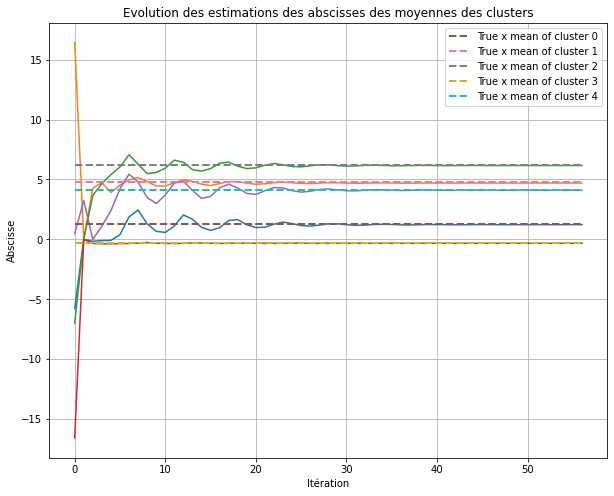

In [ ]:
nb_iter_max = len(m_absc1)

plt.figure(figsize=(10, 8))
plt.plot(m_absc1)
plt.plot(m_absc2)
plt.plot(m_absc3)
plt.plot(m_absc4)
plt.plot(m_absc5)

plt.plot(np.arange(nb_iter_max),mu[0][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 0', ls='--')
plt.plot(np.arange(nb_iter_max),mu[1][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 1', ls='--')
plt.plot(np.arange(nb_iter_max),mu[2][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 2', ls='--')
plt.plot(np.arange(nb_iter_max),mu[3][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 3', ls='--')
plt.plot(np.arange(nb_iter_max),mu[4][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 4', ls='--')

plt.title("Evolution des estimations des abscisses des moyennes des clusters")
plt.xlabel("Itération")
plt.ylabel("Abscisse")
plt.grid(True)
plt.legend()

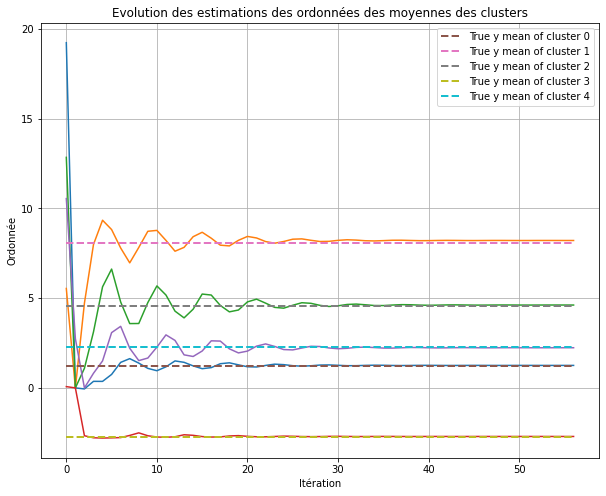

In [ ]:
nb_iter_max = len(m_absc1)

plt.figure(figsize=(10, 8))
plt.plot(m_ord1)
plt.plot(m_ord2)
plt.plot(m_ord3)
plt.plot(m_ord4)
plt.plot(m_ord5)

plt.plot(np.arange(nb_iter_max),mu[0][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 0', ls='--')
plt.plot(np.arange(nb_iter_max),mu[1][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 1', ls='--')
plt.plot(np.arange(nb_iter_max),mu[2][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 2', ls='--')
plt.plot(np.arange(nb_iter_max),mu[3][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 3', ls='--')
plt.plot(np.arange(nb_iter_max),mu[4][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 4', ls='--')

plt.title("Evolution des estimations des ordonnées des moyennes des clusters")
plt.xlabel("Itération")
plt.ylabel("Ordonnée")
plt.grid(True)
plt.legend()

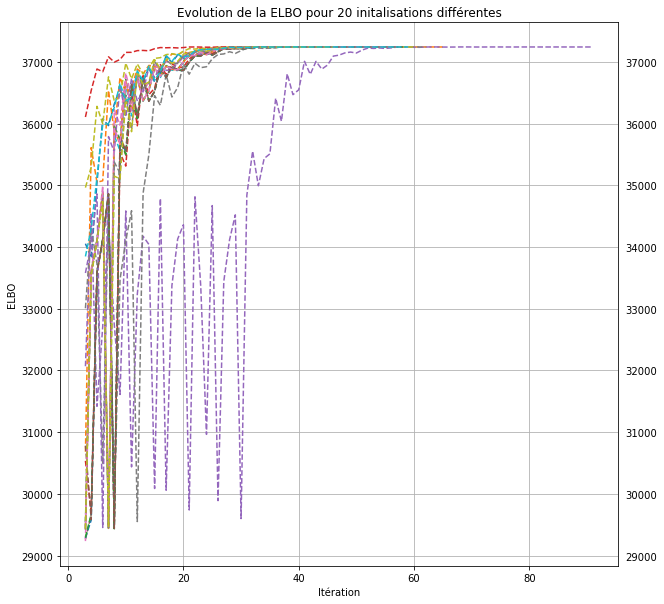

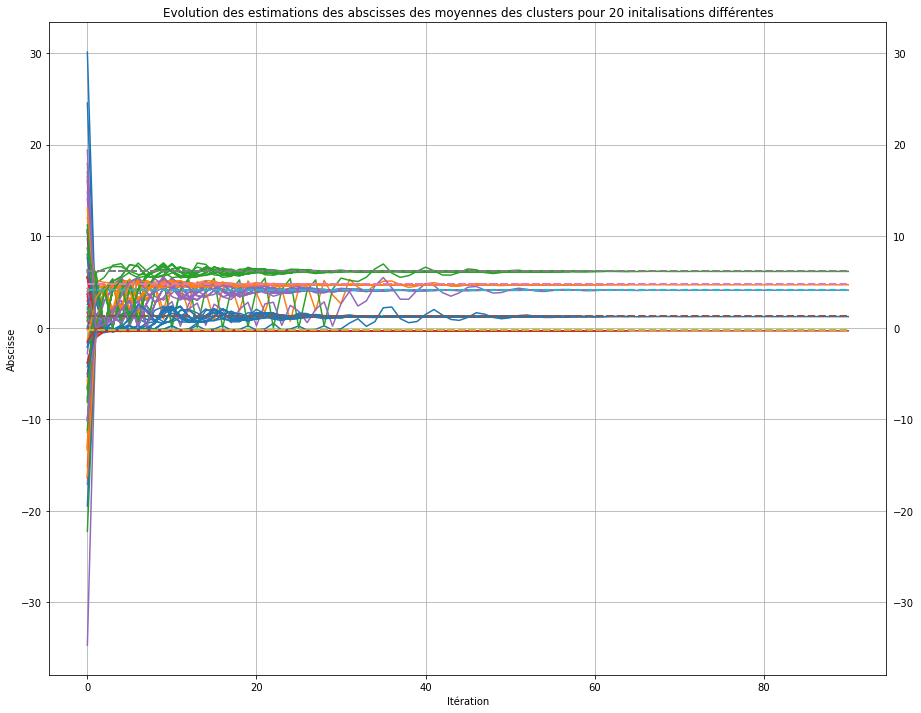

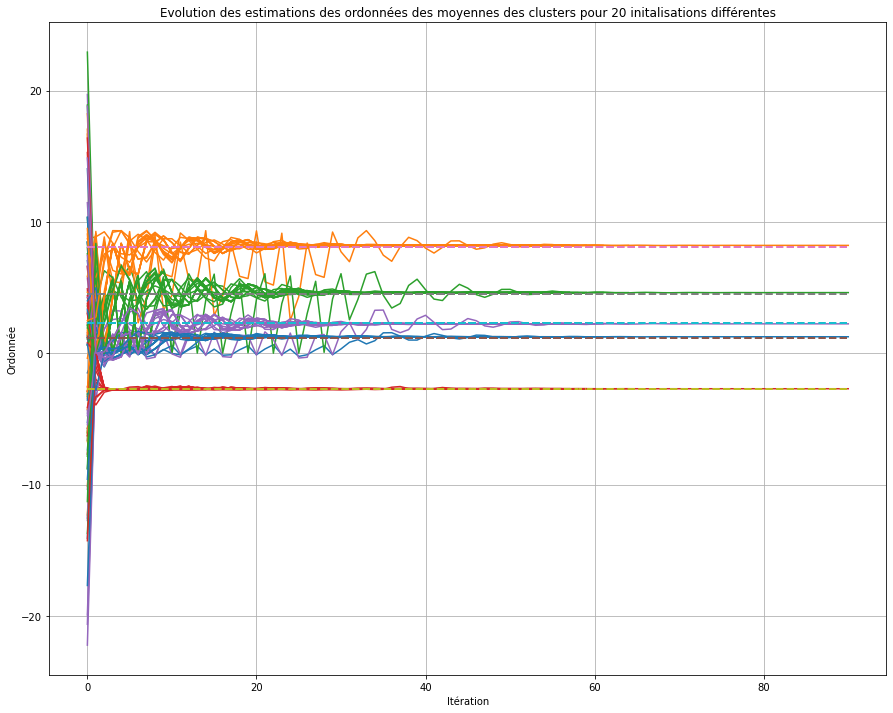

In [ ]:
nb_iter_max = 0
nb_initialisations = 20
for _ in range(nb_initialisations): # On teste 20 initialisation différentes
    # Initialization
    
    #phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
    #m_init = np.random.normal(0, 1, K)
    #s2_init = np.ones(K) * np.random.random(K)
    
    phi_init = np.random.dirichlet([np.random.random() * np.random.randint(1, 10)] * K, n_samples)
    m_init = np.random.normal(0, 10, (K,dim))
    s2_init = np.random.normal(0, 10, (K, dim, dim))
    sigma2_init = np.array([[1, 0],
                            [0, 1]])
    elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, sigma2_init)
    
    #elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
    nb_iter = np.array(elbos).size
    if nb_iter>nb_iter_max:
        nb_iter_max = nb_iter
    
    plt.figure(0, figsize=(10,10))
    #plt.plot(np.array(elbos[2::]), '--')
    plt.plot(np.arange(3, nb_iter+1), np.array(elbos[2:]), '--') # On commence à partir de la troisième valeur d'ELBO calculée pour éviter d'avoir des valeurs trop extrêmes au début
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.title("Evolution de la ELBO pour {} initalisations différentes".format(nb_initialisations))
    plt.xlabel('Itération')
    plt.ylabel('ELBO')
    
    m_absc1 = [[row[0, 0]] for row in m_est] # Evolution de l'abscisse de la moyenne du premier cluster au cours des itérations
    m_absc2 = [[row[1, 0]] for row in m_est]
    m_absc3 = [[row[2, 0]] for row in m_est]
    m_absc4 = [[row[3, 0]] for row in m_est]
    m_absc5 = [[row[4, 0]] for row in m_est]

    m_ord1 = [[row[0, 1]] for row in m_est]
    m_ord2 = [[row[1, 1]] for row in m_est]
    m_ord3 = [[row[2, 1]] for row in m_est]
    m_ord4 = [[row[3, 1]] for row in m_est]
    m_ord5 = [[row[4, 1]] for row in m_est]
    
    nb_iter_max = len(m_absc1)

    plt.figure(1, figsize=(15, 12))
    plt.plot(m_absc1)
    plt.plot(m_absc2)
    plt.plot(m_absc3)
    plt.plot(m_absc4)
    plt.plot(m_absc5)

    plt.plot(np.arange(nb_iter_max),mu[0][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 0', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[1][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 1', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[2][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 2', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[3][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 3', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[4][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 4', ls='--')

    plt.tick_params(labelright=True)
    plt.title("Evolution des estimations des abscisses des moyennes des clusters pour {} initalisations différentes".format(nb_initialisations))
    plt.xlabel("Itération")
    plt.ylabel("Abscisse")
    plt.grid(True)
    
    nb_iter_max = len(m_absc1)

    plt.figure(2, figsize=(15, 12))
    plt.plot(m_ord1)
    plt.plot(m_ord2)
    plt.plot(m_ord3)
    plt.plot(m_ord4)
    plt.plot(m_ord5)

    plt.plot(np.arange(nb_iter_max),mu[0][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 0', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[1][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 1', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[2][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 2', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[3][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 3', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[4][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 4', ls='--')

    plt.title("Evolution des estimations des ordonnées des moyennes des clusters pour {} initalisations différentes".format(nb_initialisations))
    plt.xlabel("Itération")
    plt.ylabel("Ordonnée")
    plt.grid(True)

In [ ]:
elbos

[-158471.865213443,
 17945.82922876607,
 33846.80205402293,
 34303.59476711946,
 35125.28409396077,
 35981.161492874795,
 35999.62044049623,
 36261.64342274218,
 36650.12948489291,
 36370.53392052688,
 36414.64125940328,
 36853.90572169331,
 36696.24072474221,
 36929.76027718667,
 36704.03989209086,
 36841.77100477687,
 37101.33578903612,
 37008.83873372074,
 37120.03656791007,
 37076.78891266634,
 37099.00724582518,
 37178.41200108414,
 37196.01084033712,
 37202.68948671242,
 37209.277206102706,
 37201.58351381495,
 37222.04541924862,
 37236.997123916466,
 37234.7431333131,
 37234.731968035325,
 37231.174434654145,
 37234.05680497914,
 37240.32441591063,
 37241.47907647024,
 37240.1419012549,
 37238.39572646027,
 37238.10358579303,
 37240.072389719644,
 37241.43936644921,
 37241.149869834866,
 37240.2375815852,
 37239.68849632418,
 37240.11118688451,
 37240.84737361631,
 37241.02622147551,
 37240.688953073506,
 37240.320615750294,
 37240.30829032637,
 37240.59052971979,
 37240.7893525

In [ ]:
s2_est[-1]

array([[[0.00264494, 0.        ],
        [0.        , 0.00264494]],

       [[0.00253679, 0.        ],
        [0.        , 0.00253679]],

       [[0.0022951 , 0.        ],
        [0.        , 0.0022951 ]],

       [[0.00244673, 0.        ],
        [0.        , 0.00244673]],

       [[0.00257532, 0.        ],
        [0.        , 0.00257532]]])

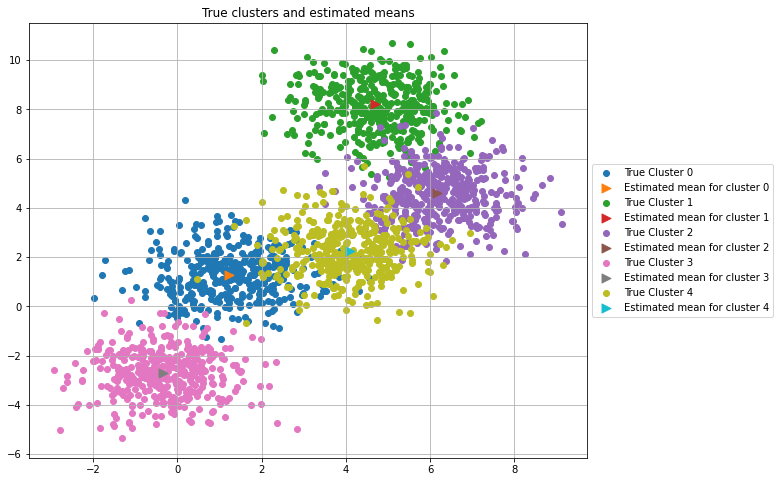

In [ ]:
# Posterior distribution of the means in each group

plt.figure(figsize=(10, 8))
plt.grid(True)
for i in range(K):
    plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"True Cluster {i}")
    plt.legend()
    cov, mean = s2_est[-1][i], m_est[-1][i,:] ## Latest value of the estimators
    plt.scatter(mean[0], mean[1], s=80, marker=">", label=f"Estimated mean for cluster {i}")
    #print(cov.shape, mean.shape)
    #data = np.random.multivariate_normal(mean, cov, 100)
    # x, y = data[:,0], data[:,1]
    #sns.kdeplot(x, y, cmap="Blues", shade=True, thresh=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("True clusters and estimated means")
plt.show()

It's normal to have small values in the estimator of the covariance matrix of the posterior distribution of the means (in the mean-field ) in each groupe.

- Once we have a fitted variational density, we can use it as we
would use the posterior. For example, we can obtain a posterior decomposition of the data. We assign points to their most likely mixture assignment
$c_i = \arg \underset{1 \leq k \leq K} \max  ϕ_i(k)$ and estimate cluster
means with their variational means $m_k$.

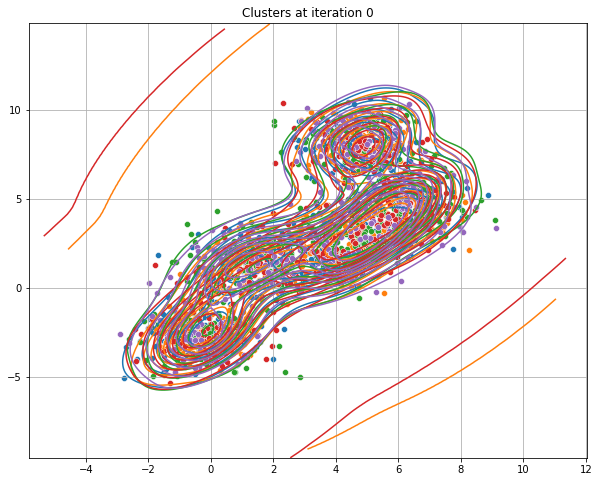

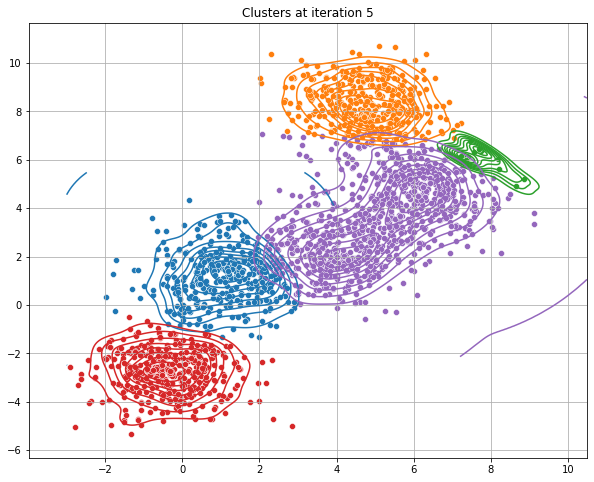

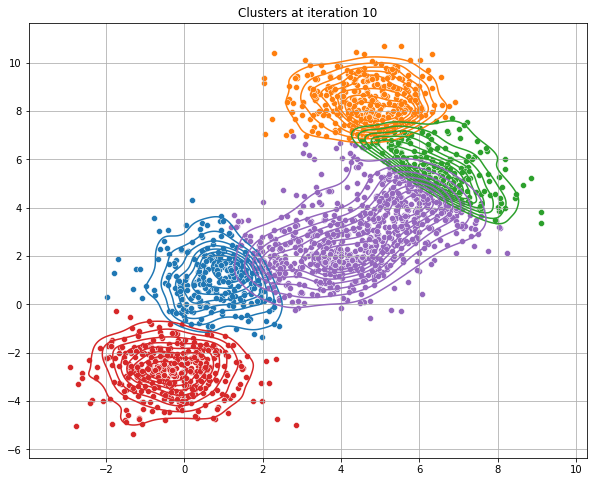

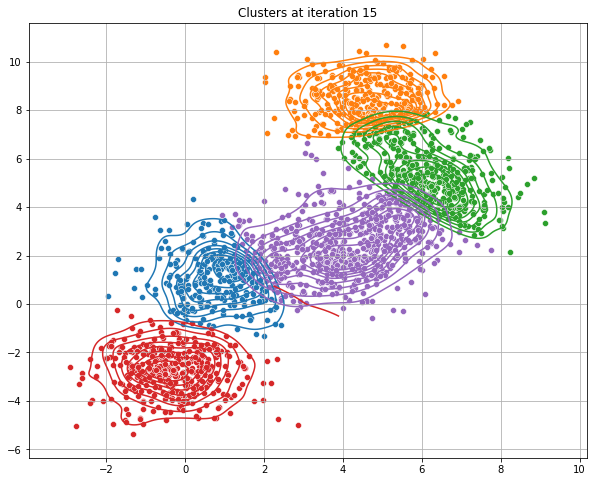

In [ ]:
warnings.filterwarnings('ignore')

for j in range(0, len(phi_est)):
    if j%5 == 0  and j < 20:
        plt.figure(figsize=(10, 8))
        plt.grid(True)
        C = phi_est[j].argmax(axis=1)
        for i in list(set(C)):
            # cov, mean = s2_est[j][i], m_est[j][i,:]
            # plt.scatter(mean[0], mean[1], s=80, marker=">", label=f"Estimated mean for cluster {i}")
            sns.kdeplot(X[C==i, 0], X[C==i, 1], thresh=0)
            sns.scatterplot(X[C == i, 0], X[C == i,1])
            plt.title(f"Clusters at iteration {j}")
            plt.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plt.close()

def h(j):
    C = phi_est[j].argmax(axis=1)
    ax.scatter(X[:, 0], X[:,1], c=C)
    ax.set_title(f"Clusters at iteration {j}")

In [ ]:
#plt.grid()
anim = animation.FuncAnimation(fig, h, len(phi_est), repeat = False, interval=5)
rc('animation', html='jshtml')
anim

The borders between between clusters seems to be linear. Actually it's not surprising given that

\begin{align*}
c_i &= \arg \underset{1 \leq k \leq K} \max  ϕ_i(k)\\
& = \arg \underset{1 \leq k \leq K} \max \exp(x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2})\\
&= \arg \underset{1 \leq k \leq K} \max \log \left( \exp \left(x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2} \right) \right)\\
&= \arg \underset{1 \leq k \leq K} \max x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2}\\
&= \arg \underset{1 \leq k \leq K} \max x_i^T.w_k + b_k && \text{$w_k = m_k$ and $b_k = - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2}$}
\end{align*}
We can see that the decision is linear is x which explains the observed borders of the clusters. 

In [ ]:
### Get clusters
C = phi_est[-1].argmax(axis=1)
score = adjusted_rand_score(labels_true=idx, labels_pred=C)
print(f"Quality of the clustering: {round(score, 3)}")

Quality of the clustering: 0.835


# <font color=darkcyan> Application to the Image Analysis</font>

First of all, we first wanted to use the same dataset, the ImageCLEF dataset, used in the research paper. However, this one isn't available because a registration is required to downloaded it. Consequently, we decided to use an other one, which was available on Kaggle. 

Because of the significant size of this databaset, we wasn't able to upload it on Github, so here is the procedure to download and use it for this Notebook :
- Download the dataset from the following link : https://www.kaggle.com/hsankesara/flickr-image-dataset
- Unzip and place the file called "flickr30k_images" in the same repository as this notebook
Now, everything is correctly set up !

<font color=darkred>Preprocessing of the data</font>

In [3]:
"""""""""""""""""
Required packages
"""""""""""""""""
import pandas as pd
import random
import imageio
import cv2

In [ ]:
# Importation of the dataset

data_dir = "flickr30k_images/flickr30k_images/"

df = pd.read_csv("flickr30k_images/results.csv", sep="|")

df.head(10)

NameError: name 'pd' is not defined

In [ ]:
# Get the name of each columns

df.columns

In [ ]:
# Extraction of image's filename

filename_df = df["image_name"]
filename = filename_df.values

In [ ]:
# Creation of our training and testing dataset

nb_files = len(filename) # number of images in the whole dataset
nb_dataset = 10000 # size of training data

files_image_analysis = []
compteur = 0
while compteur < nb_dataset:
    temp = random.choice(filename)
    if temp not in files_image_analysis:
        files_image_analysis.append(temp)
        compteur += 1

print(len(files_image_analysis))

#print(files_image_analysis)

In [ ]:
# Useful functions for images

def read_image(file_name):
    img_color = imageio.imread(file_name)
    return img_color

def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

img = read_image(data_dir+files_image_analysis[0])
display_image(img)
img.shape

In [ ]:
# Test for the histogram of one image

color = ('b','g','r')
img_hist = []
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[192],[0,192])
    #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
    img_hist += histr.tolist() 
    plt.plot(histr,color = col)
    plt.xlim([0,200])
plt.show()

print(np.shape(img_hist))

As it is mentionned in the reasearch paper, we are going to do our colour clusterisation according to the RGB histogram of each images of the dataset we created above. 

To do so, we will compute the histogram of each colour channel of each images. We will consider a length of 192, the same as in the research paper, for each colour histogramm. Then, we will concatenate them in order to have a single. Thus, each image will be represented by a sequence of length 576.

<font color=darkred>Creation of the dataset that will be feed to the model</font>

In [ ]:
# Concatenation of the 3 histograms (RGB) of each image of the dataset into one single array
# The length will be the sum of the length of each histogram 

dataset = []
for file_name in files_image_analysis:
    img = read_image(data_dir+file_name)
    img_hist = []
    for i in range(3):
        histr = cv2.calcHist([img],[i],None,[192],[0,192])
        #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
        img_hist += (histr.reshape(-1,1)).tolist()
    dataset.append(img_hist)

In [ ]:
print(np.array(dataset)[:,:,0].shape)

In [ ]:
# We update only one function that was introduced before, in order to fit to our problem

def CAVI_update_phi(X, m, s2):
    """
    :param X: our data points
    :param m: estimated mean in the law q
    :param s2: estimated variance in the law q
    :return: the updated phi
    """
    
    first_term = X @ m.T

    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    x = first_term + second_term
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

<font color=darkred>Run the algorithm</font>

In [ ]:
K = 30 # nb of clusters
dim = 576
dataset = np.array(dataset)[:,:,0]

phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, nb_dataset)
m_init = np.random.normal(0, 10, (K,dim))
s2_init = np.random.normal(0,10,(K,dim,dim))
sigma2_init = np.identity(dim)
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)
print(sigma2_init.shape)

In [ ]:
fig = plt.figure(figsize=(8,5))
%time elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(dataset, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

In [ ]:
print(elbos)

In [ ]:
m_est[-1]

In [ ]:
s2_est[-1]

In [ ]:
# Get the cluster of each images

list_clusterisation = phi_est[-1].argmax(axis=1)   
print(list_clusterisation)

In [ ]:
# Storage of each image in the cluster that belongs to it

list_cluster_image = [[] for k in range(K)]

for idx, cluster in enumerate(list_clusterisation) :
    list_cluster_image[cluster].append(files_image_analysis[idx])

print(list_cluster_image)

In [ ]:
# Check of the population of each clusters

for k in range(K):
    print(len(list_cluster_image[k]))

In [ ]:
# Plot of the images of each clusters

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 9 :
        #print("Cluster n°" + str(k))
        #print(len(cluster))

        f, axarr = plt.subplots(3,3)
        plt.figure(figsize=(15.0, 4.0))

        axarr[0,0].imshow(read_image(data_dir+cluster[0]))
        axarr[0,1].imshow(read_image(data_dir+cluster[1]))
        axarr[0,2].imshow(read_image(data_dir+cluster[2]))
        axarr[1,0].imshow(read_image(data_dir+cluster[3]))
        axarr[1,1].imshow(read_image(data_dir+cluster[4]))
        axarr[1,2].imshow(read_image(data_dir+cluster[5]))
        axarr[2,0].imshow(read_image(data_dir+cluster[6]))
        axarr[2,1].imshow(read_image(data_dir+cluster[7]))
        axarr[2,2].imshow(read_image(data_dir+cluster[8]))
        
        f.suptitle("Cluster n°" + str(k) + " contenant " + str(len(cluster)) + " images", fontsize=15)
        
        f.tight_layout()

As we can see, each clusters show images that have similary colour. Let check the histogram of images of each clusters

In [ ]:
# Plot of the histogram of an image in each cluster

color = ('b','g','r')

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 3:
        #print("Cluster n°" + str(k))
        #print(len(cluster))
        plt.figure(figsize=(15.0, 4.0))
        
        plt.subplot(1,3,1)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[0])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        
        plt.subplot(1,3,2)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[1])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        plt.title("Cluster n°" + str(k) + " contenant " + str(len(cluster)) + " images", fontsize=15)
            
        plt.subplot(1,3,3)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[2])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])

We can see that the clusterisation is great as the histograms in each clusters are quite similary